In [1]:
#импортируем разное
import tensorflow as tf

from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

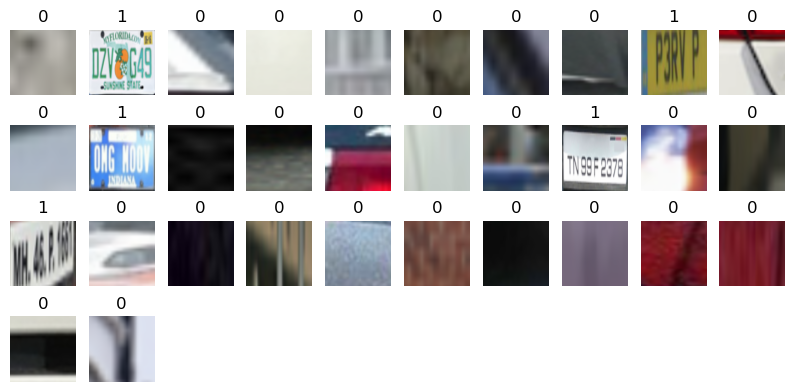

2024-06-09 21:29:03.975984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('classifier_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'name': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    name = tf.io.parse_tensor(parsed_record['name'], out_type=tf.int32)
    return img, name

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим


dataset = dataset.shuffle(50).cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(64).shuffle(50)

for i, n in dataset.take(1):
    plt.figure(figsize=(10, 6))
    i = i.numpy()
    n = n.numpy()
    for nn in range(32):
        
        ax = plt.subplot(5, 10, 1 + nn)
        
        plt.title(n[nn])
        plt.imshow(i[nn])
        plt.axis('off')
    plt.show()

In [3]:


base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(128,128, 3))
base_model.trainable = False

In [7]:
import keras
from keras.layers import Dense, Flatten, Input, Conv2D, GlobalAveragePooling2D, Dropout

#давайте напишем нейросеть

inputs = Input((128,128,3))
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation = 'softmax')(x)

outputs = x

classifier = keras.Model(inputs, outputs)

In [9]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        self.optimizer = tf.keras.optimizers.Adam(1e-3)
        
    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(tf.one_hot(y, 3),preds)
        return loss
        
    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:
            
            preds = self.nn(x)
            loss = self.get_loss(y, preds)
            
        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)   
    
model = Model(classifier)

In [11]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

tf.Tensor(0.9290817, shape=(), dtype=float32)


2024-06-09 21:29:18.713322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5


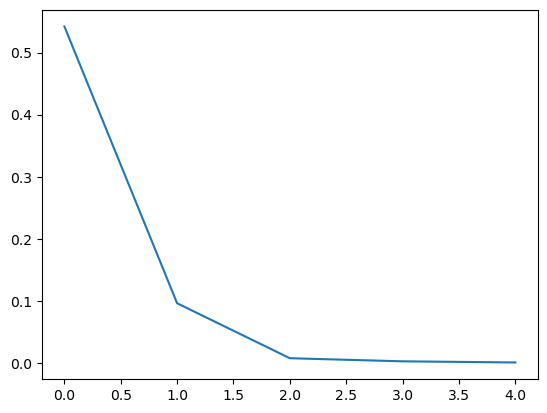

In [13]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 5

for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, n) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,n))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()

[1.0000000e+00 4.3299238e-29 0.0000000e+00]
[1.0000000e+00 2.4732594e-22 0.0000000e+00]
[1.0000000e+00 2.6530935e-09 0.0000000e+00]
[1.0000000e+00 1.0027478e-20 0.0000000e+00]
[1.0000000e+00 3.2482366e-22 0.0000000e+00]
[1.000000e+00 7.714304e-21 0.000000e+00]
[1.0000000e+00 2.0752674e-17 0.0000000e+00]
[1.000000e+00 6.551905e-17 0.000000e+00]
[1.0000000e+00 6.2002824e-18 0.0000000e+00]
[1.0000000e+00 2.2718067e-08 0.0000000e+00]
[1.000000e+00 2.807733e-26 0.000000e+00]
[1.0000000e+00 1.1691931e-17 0.0000000e+00]
[1.0000000e+00 5.0778316e-25 0.0000000e+00]
[1.00000e+00 3.48461e-22 0.00000e+00]
[1.0000000e+00 1.5077847e-21 0.0000000e+00]
[9.9999881e-01 1.2009543e-06 0.0000000e+00]
[1.00000e+00 6.26768e-17 0.00000e+00]
[1.0000000e+00 2.0227981e-25 0.0000000e+00]
[1.0000000e+00 2.0822192e-27 0.0000000e+00]
[1.000000e+00 9.258873e-22 0.000000e+00]
[1.0000000e+00 1.9439653e-23 0.0000000e+00]
[9.999883e-01 1.166518e-05 0.000000e+00]
[1.0000000e+00 2.7066722e-15 0.0000000e+00]
[1.0000000e+00 

2024-06-09 21:30:03.352022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


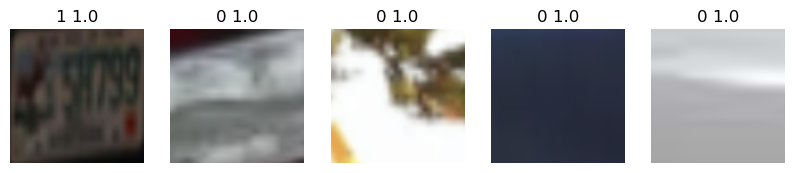

In [15]:
def imshow_and_pred():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(10):
        preds = model.nn(images)
        for i in range(n):
            img = images[i]
            
            
            pred = preds[i].numpy()
            print(pred)
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            
            ma = pred.max()
            res = np.where(pred == ma)
            
            plt.title(str(res[0][0]) +' '+ str(round(pred[res[0][0]], 3)))
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow_and_pred()

In [17]:
model.nn.save('my_classifier.h5')